In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

%matplotlib inline

In [2]:
fname = 'average-precipitation-1901-2020_br__germany.csv'

df = pd.read_csv(fname,index_col ='Category'). \
    rename(columns={'Annual Mean' : 'Precipitation'}). \
    drop(columns=['Smoothed'])

In [3]:
df

,Precipitation
Category,
1901,661.28
1902,649.45
1903,693.60
1904,611.27
1905,705.02
...,...
2016,692.90
2017,793.69
2018,557.95


In [4]:
df['SMA5'] = df.Precipitation.rolling(5,min_periods=1). \
    mean().shift(1)

df['SMA10'] = df.Precipitation.rolling(10,min_periods=1). \
    mean().shift(1)

In [5]:
df

,Precipitation,SMA5,SMA10
Category,,,
1901,661.28,NaN,NaN
1902,649.45,661.280,661.280
1903,693.60,655.365,655.365
1904,611.27,668.110,668.110
1905,705.02,653.900,653.900
...,...,...,...
2016,692.90,682.718,715.559
2017,793.69,690.308,716.808
2018,557.95,708.000,709.853


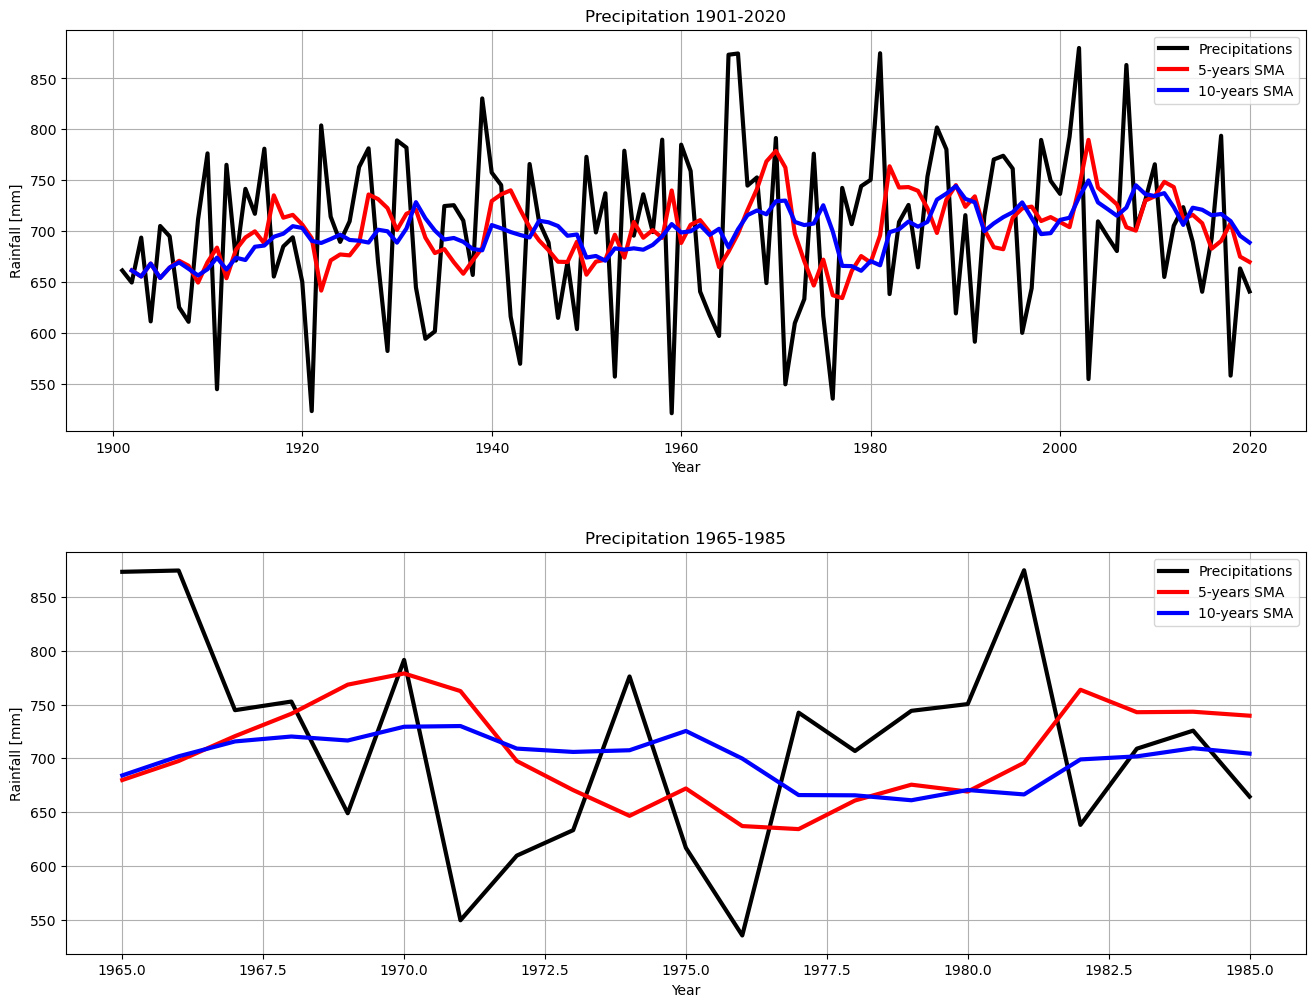

In [8]:

fig , axs = plt.subplots(nrows=2,ncols=1, \
    figsize = (16,12), dpi=100)

plt.subplots_adjust(hspace=0.3)

colors = ['k','red','blue']

df.plot(ax=axs[0], color = colors, linewidth=3)

axs[0].set_title('Precipitation 1901-2020')
axs[0].set(xlabel='Year', ylabel='Rainfall [mm]')
axs[0].legend(labels=['Precipitations', \
    '5-years SMA', '10-years SMA'])
axs[0].grid()

df.loc[1965:1985].plot(ax=axs[1], color =colors, \
    linewidth = 3)

axs[1].set_title('Precipitation 1965-1985')
axs[1].set(xlabel='Year', ylabel='Rainfall [mm]')
axs[1].legend(labels=['Precipitations', \
    '5-years SMA', '10-years SMA'])
axs[1].grid()


In [9]:
# %% define a function to calculate the AIC
# y: original data
# yhat: SMA data
# npar: number of parameters (by default equal to 2)

def get_AIC(y,yhat,npar=2):
    N=len(y)
    error = y-yhat
    likelihood = (N/2) * np.log(2*np.pi) + \
        (N/2)*np.log(error.var()) + (N/2)
    result = 2*npar - 2*likelihood
    return(result)

aic_5 = get_AIC(df.Precipitation,df['SMA5'])
aic_10 = get_AIC(df.Precipitation,df['SMA10'])

In [10]:
print('SMA(5) - AIC: ', aic_5)
print('SMA(10) - AIC: ', aic_10)

SMA(5) - AIC:  -1414.0229514348625
SMA(10) - AIC:  -1402.6497628190984


In [11]:
# %% define a function for SMA out-of-sample forecasting
# data: original data
# q: SMA order
# h: forecast horizon

def getSMAForecast(data,q,h):
    # create a list of zeros for h
    # to be forecasted values plus the last
    # q observed values (size of the window)
    fc= np.zeros(q+h)

    # fill the first q forecast values
    # with the last q observed data points
    fc[:q] = data[-q:]

    # iterate over the h to be forecasted values
    for i in range(h):

        # calculate the current forecast as the
        # mean of the q past values
        fc[q+i] = fc[i:i+q].mean()

    # remove the observed data from the forecast
    fc = fc[q:]

    return fc

In [12]:
fc = getSMAForecast(data = df.Precipitation, q=5,h=20)

fc = pd.DataFrame(fc,columns=['MA1'])

df = pd.concat([df,fc], ignore_index=True)

df = df.set_index([pd.Index(df.index.values+1901)])

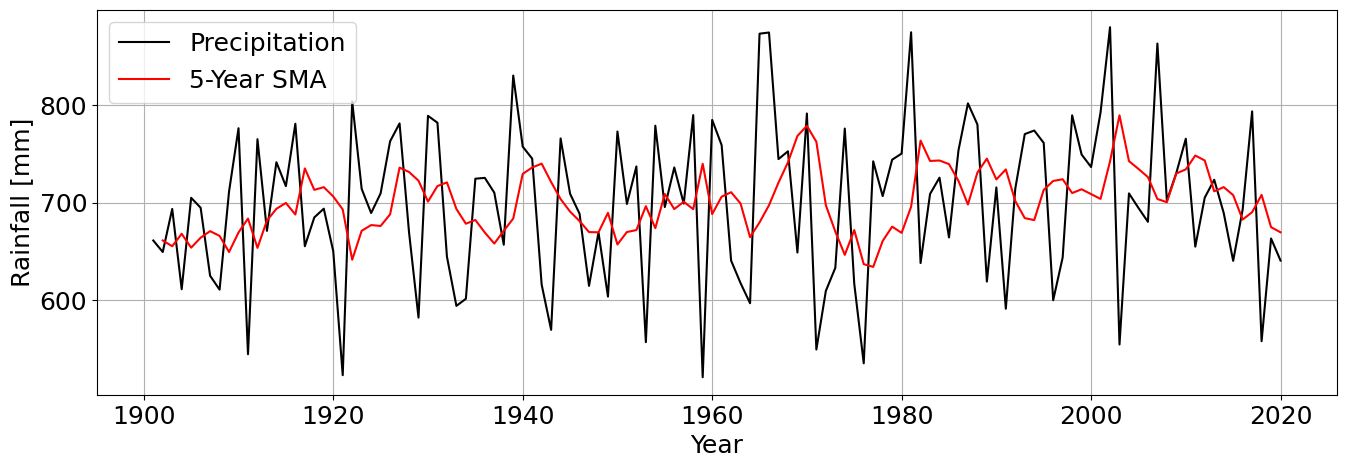

In [15]:
plt.rcParams.update({'font.size' : 18})
plt.figure(figsize=(16,5), dpi=100)

plt.plot(df.index, df.Precipitation, color = 'k')
plt.plot(df.index, df['SMA5'], color = 'red')

plt.gca().set(xlabel = 'Year', ylabel =  'Rainfall [mm]')
plt.legend(labels = [ 'Precipitation', '5-Year SMA'])
plt.grid()
plt.show()

In [16]:
df

,Precipitation,SMA5,SMA10,MA1
1901,661.28,NaN,NaN,NaN
1902,649.45,661.280,661.280,NaN
1903,693.60,655.365,655.365,NaN
1904,611.27,668.110,668.110,NaN
1905,705.02,653.900,653.900,NaN
...,...,...,...,...
2036,NaN,NaN,NaN,654.057815
2037,NaN,NaN,NaN,653.999669
2038,NaN,NaN,NaN,654.026277
2039,NaN,NaN,NaN,654.070316


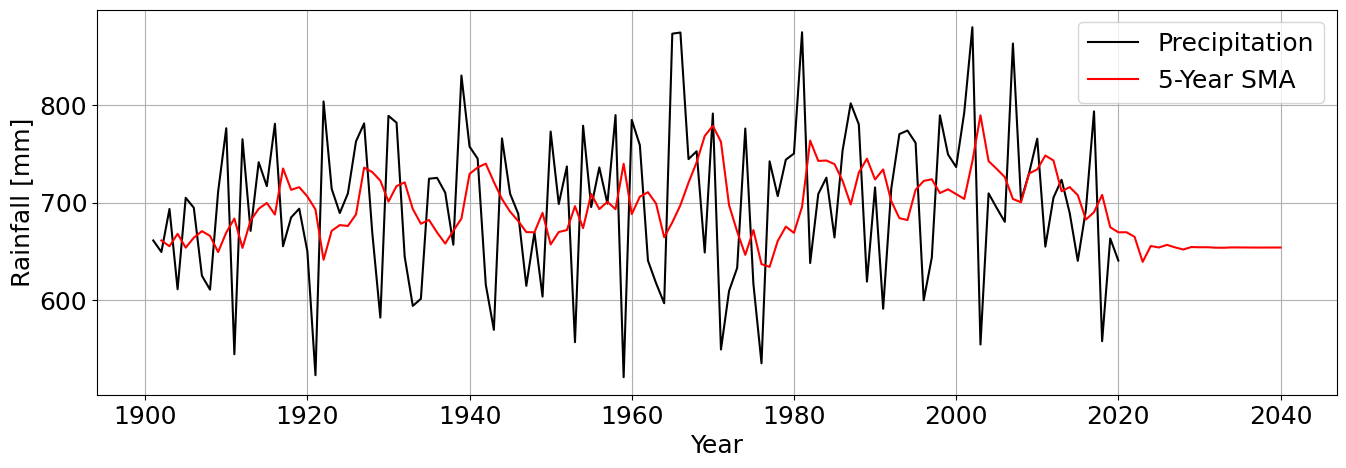

In [20]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your data
fname = 'average-precipitation-1901-2020_br__germany.csv'
df = pd.read_csv(fname, index_col='Category').rename(columns={'Annual Mean': 'Precipitation'}).drop(columns={'Smoothed'})
df.index = df.index.rename('Year')

# Calculate the 5-year SMA
df['SMA5'] = df.Precipitation.rolling(5, min_periods=1).mean().shift(1)

# Forecasting function (for SMA-based forecasts)
def getSMAForecast(data, q, h):
    fc = np.zeros(q + h)
    fc[:q] = data[-q:]
    for i in range(h):
        fc[q + i] = fc[i:i + q].mean()
    fc = fc[q:]
    return fc

# Forecast 20 future years (up to 2040)
forecast_horizon = 20  # Forecasting 20 years into the future
forecast_start_year = df.index[-1] + 1  # Start year for forecast
future_years = np.arange(forecast_start_year, forecast_start_year + forecast_horizon)

# Get SMA forecast
fc = getSMAForecast(data=df.Precipitation, q=5, h=forecast_horizon)

# Convert forecast to DataFrame with future years as index
fc_df = pd.DataFrame(fc, index=future_years, columns=['SMA5'])

# Append forecasted values to the original DataFrame
df_forecast = pd.concat([df, fc_df])

# Plot the precipitation measurements & SMA(5) forecast
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(16,5), dpi=100)

# Plot original data
plt.plot(df_forecast.index, df_forecast.Precipitation, color='k', label='Precipitation')

# Plot the SMA(5) forecast
plt.plot(df_forecast.index, df_forecast['SMA5'], color='red', label='5-Year SMA')

# Set labels, legend, and grid
plt.gca().set(xlabel='Year', ylabel='Rainfall [mm]')
plt.legend(labels=['Precipitation', '5-Year SMA'])
plt.grid()

# Show the plot
plt.show()


In [21]:
df_forecast

,Precipitation,SMA5
1901,661.28,NaN
1902,649.45,661.280000
1903,693.60,655.365000
1904,611.27,668.110000
1905,705.02,653.900000
...,...,...
2036,NaN,654.057815
2037,NaN,653.999669
2038,NaN,654.026277
2039,NaN,654.070316
